# FDIA Simulation on PMU Data

This notebook demonstrates how to simulate False Data Injection Attacks (FDIA) on PMU data.

**Workflow:**
1. Load the cleaned PMU dataset.
2. Filter normal samples for attack simulation.
3. Inject three types of FDIA attacks.
4. Merge normal, fault, and FDIA samples.
5. Visualize the differences.
6. Save the new datasets.

## 1. Load Cleaned Dataset

Load the processed PMU data and filter for normal samples (label == 0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
data_path = '../data/processed/PMU_data.csv'
df = pd.read_csv(data_path)

# Filter normal and fault samples
df_normal = df[df['label'] == 0].copy()
df_fault = df[df['label'] == 1].copy()
print(f'Normal samples: {len(df_normal)}, Fault samples: {len(df_fault)}')
df_normal.head()

Normal samples: 86400, Fault samples: 15247


,timestamp,delay_at_arrival,frequency,df/dt,V_a_mag,V_a_ang,I_a_mag,I_a_ang,V_b_mag,V_b_ang,I_b_mag,I_b_ang,V_c_mag,V_c_ang,I_c_mag,I_c_ang,label
0,0,0.041158,50.014973,0.105413,12330.49316,2.434143,6.173104,2.594195,12355.28223,0.341338,5.400779,0.377317,12304.64258,-1.748062,5.250762,-1.524829,0
1,1,0.040803,50.002144,-0.010861,12327.85840,2.780275,5.982968,2.946683,12352.78320,0.687731,5.221993,0.726459,12304.61035,-1.401731,5.051753,-1.169805,0
2,2,0.039932,49.987171,-0.002415,12317.62305,2.494382,5.971821,2.656734,12343.67090,0.401813,5.192584,0.438961,12294.09180,-1.687766,5.054627,-1.455235,0
3,3,0.040460,49.980846,0.008056,12319.24414,1.475278,5.985885,1.636201,12344.62500,-0.617547,5.225528,-0.579584,12293.43066,-2.706916,5.073850,-2.478405,0
4,4,0.040020,49.974667,0.004987,12297.65820,0.156260,5.995246,0.321282,12318.87695,-1.936581,5.257210,-1.892123,12269.51758,2.257562,5.114569,2.483838,0


## 2. FDIA Attack Functions

Define modular functions to inject different types of FDIA attacks.

In [2]:
def fdia_voltage_angle_shift(df, shift_std=0.02):
    df_attacked = df.copy()
    for col in ['V_a_ang', 'V_b_ang', 'V_c_ang']:
        # Cumulative small random walk
        noise = np.random.normal(0, shift_std, size=len(df_attacked)).cumsum()
        df_attacked[col] += noise
    df_attacked['label'] = 2
    return df_attacked

def fdia_phase_current_zeroing(df):
    df_attacked = df.copy()
    df_attacked['I_a_mag'] = 0
    df_attacked['I_a_ang'] = 0
    df_attacked['label'] = 2
    return df_attacked

def fdia_frequency_drift(df, drift_rate=0.0001):
    df_attacked = df.copy()
    drift = np.linspace(0, drift_rate * len(df_attacked), len(df_attacked))
    df_attacked['frequency'] += drift
    if 'df/dt' in df_attacked.columns:
        df_attacked['df/dt'] += np.gradient(drift)
    df_attacked['label'] = 2
    return df_attacked

## 3. Inject FDIA Attacks

Apply each attack to a copy of the normal data.

In [3]:
# Apply attacks
fdia_va_shift = fdia_voltage_angle_shift(df_normal)
fdia_current_zero = fdia_phase_current_zeroing(df_normal)
fdia_freq_drift = fdia_frequency_drift(df_normal)

# Concatenate all FDIA samples
df_fdia = pd.concat([fdia_va_shift, fdia_current_zero, fdia_freq_drift], ignore_index=True)
print(f'FDIA samples: {len(df_fdia)}')
df_fdia.head()

FDIA samples: 259200


,timestamp,delay_at_arrival,frequency,df/dt,V_a_mag,V_a_ang,I_a_mag,I_a_ang,V_b_mag,V_b_ang,I_b_mag,I_b_ang,V_c_mag,V_c_ang,I_c_mag,I_c_ang,label
0,0,0.041158,50.014973,0.105413,12330.49316,2.450953,6.173104,2.594195,12355.28223,0.321152,5.400779,0.377317,12304.64258,-1.746388,5.250762,-1.524829,2
1,1,0.040803,50.002144,-0.010861,12327.85840,2.793448,5.982968,2.946683,12352.78320,0.671290,5.221993,0.726459,12304.61035,-1.361499,5.051753,-1.169805,2
2,2,0.039932,49.987171,-0.002415,12317.62305,2.530409,5.971821,2.656734,12343.67090,0.400458,5.192584,0.438961,12294.09180,-1.638678,5.054627,-1.455235,2
3,3,0.040460,49.980846,0.008056,12319.24414,1.519394,5.985885,1.636201,12344.62500,-0.612553,5.225528,-0.579584,12293.43066,-2.686162,5.073850,-2.478405,2
4,4,0.040020,49.974667,0.004987,12297.65820,0.196668,5.995246,0.321282,12318.87695,-1.960552,5.257210,-1.892123,12269.51758,2.280187,5.114569,2.483838,2


## 4. Merge Datasets

Combine normal, fault, and FDIA samples. Shuffle and save.

In [4]:
# Merge all
df_merged = pd.concat([df[df['label'] == 0], df[df['label'] == 1], df_fdia], ignore_index=True)
df_merged = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

# Save datasets
fdia_only_path = '../data/processed/pmu_fdia_only.csv'
merged_path = '../data/processed/pmu_with_fdia.csv'
df_fdia.to_csv(fdia_only_path, index=False)
df_merged.to_csv(merged_path, index=False)
print(f'Saved FDIA-only to {fdia_only_path}')
print(f'Saved merged to {merged_path}')

Saved FDIA-only to ../data/processed/pmu_fdia_only.csv
Saved merged to ../data/processed/pmu_with_fdia.csv


## 5. Visualize Normal, Fault, and FDIA Distributions

Compare distributions for key features across normal, fault, and FDIA samples.

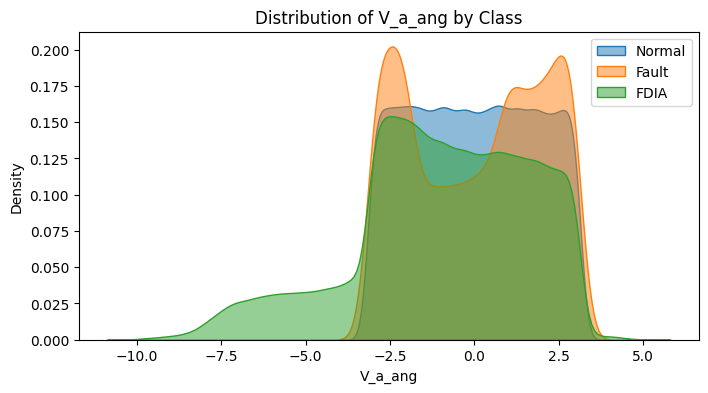

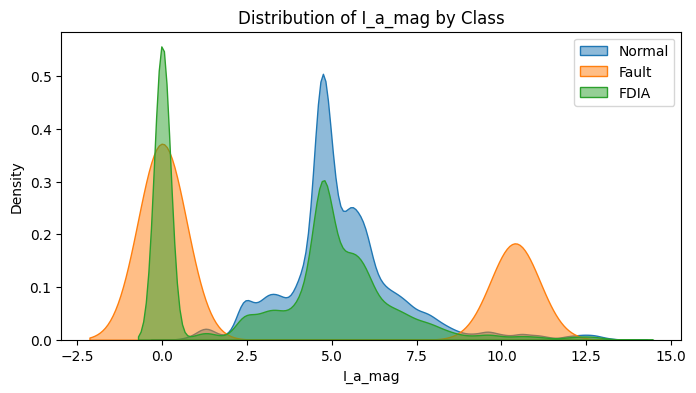

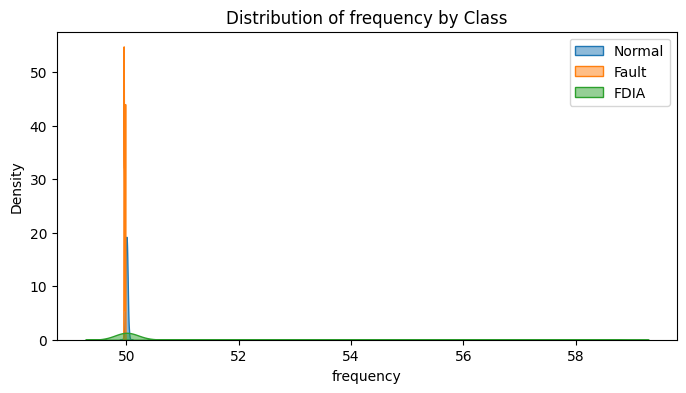

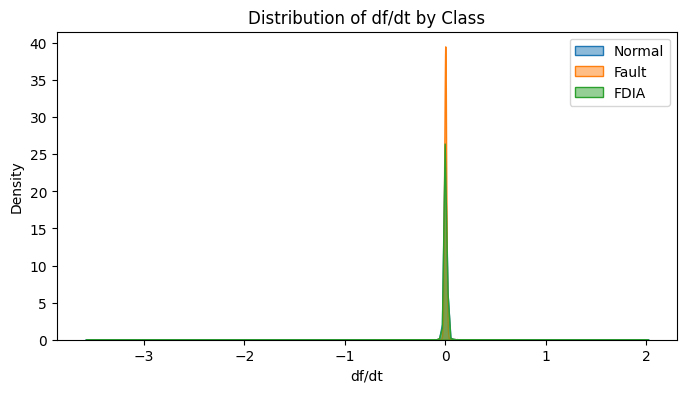

In [5]:
features_to_plot = ['V_a_ang', 'I_a_mag', 'frequency', 'df/dt']
labels_map = {0: 'Normal', 1: 'Fault', 2: 'FDIA'}
for feat in features_to_plot:
    plt.figure(figsize=(8, 4))
    for label, name in labels_map.items():
        sns.kdeplot(df_merged[df_merged['label'] == label][feat], label=name, fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {feat} by Class')
    plt.legend()
    plt.show()